# 추천시스템1 (주중/주말, 오전/오후 구분X)

In [153]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [154]:
file_path = '/content/DDUNIVDATA.csv'
data = pd.read_csv(file_path)

In [155]:
data

,yyyymm,sex,age,cst_addr_no,weekend,aftern,lclss,sale_qty,sale_amt,sale_cnt
0,202307,1,1,NaN,1,0,5,29.0,81200.0,25
1,202307,1,1,NaN,1,1,5,69.0,259700.0,61
2,202307,1,1,NaN,0,0,6,749.0,3350600.0,686
3,202307,1,1,NaN,0,1,6,1984.0,9040200.0,1779
4,202307,1,1,11.0,1,0,99,37.0,72800.0,33
...,...,...,...,...,...,...,...,...,...,...
118171,202401,2,5,46.0,0,1,3,3.0,7800.0,3
118172,202401,2,5,48.0,1,1,4,13.0,30900.0,13
118173,202401,2,5,51.0,1,0,17,16.0,24900.0,8
118174,202401,2,5,51.0,1,1,17,12.0,16300.0,11


## 1. 데이터 전처리

In [156]:
data = data.dropna()  # 결측치 제거
data # 결측치 없음..

,yyyymm,sex,age,cst_addr_no,weekend,aftern,lclss,sale_qty,sale_amt,sale_cnt
4,202307,1,1,11.0,1,0,99,37.0,72800.0,33
5,202307,1,1,11.0,1,1,99,65.0,144200.0,60
6,202307,1,1,11.0,0,0,18,508.0,1530000.0,456
7,202307,1,1,11.0,0,1,18,840.0,2936900.0,741
8,202307,1,1,26.0,1,0,3,17.0,42900.0,13
...,...,...,...,...,...,...,...,...,...,...
118171,202401,2,5,46.0,0,1,3,3.0,7800.0,3
118172,202401,2,5,48.0,1,1,4,13.0,30900.0,13
118173,202401,2,5,51.0,1,0,17,16.0,24900.0,8
118174,202401,2,5,51.0,1,1,17,12.0,16300.0,11


In [157]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107503 entries, 4 to 118175
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   yyyymm       107503 non-null  int64  
 1   sex          107503 non-null  int64  
 2   age          107503 non-null  int64  
 3   cst_addr_no  107503 non-null  float64
 4   weekend      107503 non-null  int64  
 5   aftern       107503 non-null  int64  
 6   lclss        107503 non-null  int64  
 7   sale_qty     107503 non-null  float64
 8   sale_amt     107503 non-null  float64
 9   sale_cnt     107503 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 9.0 MB


In [158]:
data.describe()

,yyyymm,sex,age,cst_addr_no,weekend,aftern,lclss,sale_qty,sale_amt,sale_cnt
count,107503.000000,107503.000000,107503.000000,107503.000000,107503.000000,107503.000000,107503.000000,107503.000000,1.075030e+05,107503.000000
mean,202353.910505,1.455615,2.812154,35.790992,0.429076,0.609760,13.558143,237.892384,5.712252e+05,175.163140
std,46.954058,0.498028,1.397595,12.395682,0.494947,0.487806,15.072845,1135.030327,3.622413e+06,821.447196
min,202307.000000,1.000000,1.000000,11.000000,0.000000,0.000000,1.000000,3.000000,1.000000e+02,3.000000
25%,202309.000000,1.000000,2.000000,28.000000,0.000000,0.000000,6.000000,8.000000,1.670000e+04,6.000000
50%,202312.000000,1.000000,3.000000,41.000000,0.000000,1.000000,11.000000,18.000000,3.960000e+04,14.000000
75%,202403.000000,2.000000,4.000000,47.000000,1.000000,1.000000,17.000000,62.000000,1.346000e+05,48.000000
max,202406.000000,2.000000,5.000000,52.000000,1.000000,1.000000,99.000000,36285.000000,1.568676e+08,25116.000000


## 2. 사용자별 구매 행동 집계

In [159]:
# 사용자 행동 데이터를 집계하기 위해 'cst_addr_no', 'sex', 'age'를 조합하여 사용자 식별자 생성
data['user_id'] = data['cst_addr_no'].astype(str) + '_' + data['sex'].astype(str) + '_' + data['age'].astype(str)
data.head()

<ipython-input-159-8c2df6111f4e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['user_id'] = data['cst_addr_no'].astype(str) + '_' + data['sex'].astype(str) + '_' + data['age'].astype(str)


,yyyymm,sex,age,cst_addr_no,weekend,aftern,lclss,sale_qty,sale_amt,sale_cnt,user_id
4,202307,1,1,11.0,1,0,99,37.0,72800.0,33,11.0_1_1
5,202307,1,1,11.0,1,1,99,65.0,144200.0,60,11.0_1_1
6,202307,1,1,11.0,0,0,18,508.0,1530000.0,456,11.0_1_1
7,202307,1,1,11.0,0,1,18,840.0,2936900.0,741,11.0_1_1
8,202307,1,1,26.0,1,0,3,17.0,42900.0,13,26.0_1_1


In [160]:
data.value_counts('user_id').isnull().sum() # 모든 행정구역, 모든 성별, 모든 나이대 데이터 다 있음

0

In [161]:
data['user_id'].value_counts() # 최대 1232 최소 43

,count
user_id,
11.0_1_4,1232
11.0_1_3,1230
11.0_1_5,1224
11.0_2_4,1222
11.0_2_2,1222
...,...
30.0_2_5,178
50.0_2_5,138
31.0_2_5,109


In [162]:
# 사용자-품목 행렬 생성
user_item_matrix = data.pivot_table(values='sale_amt', index='user_id', columns='lclss', aggfunc='sum', fill_value=0)
user_item_matrix

lclss,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,99
user_id,,,,,,,,,,,,,,,,,,,,,
11.0_1_1,233588600.0,55418100.0,175818200.0,210529200.0,34868000.0,1.254322e+09,298171000.0,209739400.0,83337400.0,87421900.0,...,275635000.0,7.896154e+08,74832200.0,105160200.0,263200.0,14835300.0,148356800.0,33080900.0,41847300.0,16787700.0
11.0_1_2,310727600.0,83659700.0,228509000.0,331127400.0,80079200.0,2.518524e+09,832054000.0,244187200.0,102748600.0,113795600.0,...,418986900.0,1.036692e+09,93550300.0,130827000.0,1129600.0,20873000.0,164036500.0,45529900.0,50747800.0,37080300.0
11.0_1_3,267266600.0,50722200.0,202813200.0,295307300.0,92560700.0,2.954568e+09,893476200.0,187771800.0,91404800.0,76128900.0,...,397649700.0,8.263923e+08,62082500.0,83967800.0,1596100.0,13347700.0,169607600.0,33524100.0,27600700.0,41427300.0
11.0_1_4,239666500.0,47813100.0,178711700.0,217746200.0,76880900.0,3.072065e+09,792604800.0,150834800.0,78798200.0,79194200.0,...,300701000.0,6.933394e+08,63910000.0,60125800.0,2282600.0,9551200.0,118464300.0,37876900.0,27444300.0,60983100.0
11.0_1_5,156892800.0,36248900.0,84790500.0,129314300.0,43323600.0,2.223574e+09,550282900.0,91168800.0,74526600.0,67780400.0,...,219749900.0,3.773868e+08,52153300.0,31552800.0,822000.0,5352200.0,71405100.0,38785900.0,20463600.0,54311800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52.0_2_1,1924400.0,732600.0,1721400.0,1735800.0,672000.0,1.005700e+06,1096300.0,1626200.0,581100.0,867200.0,...,2077600.0,6.963600e+06,1125000.0,679300.0,0.0,0.0,2011000.0,56400.0,375400.0,10100.0
52.0_2_2,583600.0,340600.0,631900.0,821900.0,436400.0,2.158600e+06,1155800.0,450000.0,121600.0,439300.0,...,1091200.0,3.835900e+06,522400.0,154400.0,0.0,0.0,750300.0,44900.0,115900.0,0.0
52.0_2_3,675700.0,337300.0,1035000.0,878300.0,301800.0,1.989700e+06,724500.0,543600.0,188000.0,384500.0,...,1335500.0,3.339700e+06,232700.0,118300.0,0.0,0.0,837200.0,0.0,78700.0,0.0


In [163]:
# 품목 간 코사인 유사도 계산
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)
item_similarity_df

lclss,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,99
lclss,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.989271,0.995163,0.989625,0.970484,0.871803,0.934622,0.986567,0.991911,0.990579,...,0.991922,0.980807,0.973791,0.948336,0.854888,0.962912,0.975554,0.980060,0.970147,0.896170
2,0.989271,1.000000,0.984994,0.978450,0.947653,0.834620,0.901735,0.982305,0.981627,0.995549,...,0.983559,0.973120,0.982557,0.948258,0.809951,0.966700,0.969446,0.978157,0.981414,0.875266
3,0.995163,0.984994,1.000000,0.993781,0.963413,0.832286,0.911437,0.982786,0.976228,0.981171,...,0.984747,0.968095,0.980556,0.936653,0.833068,0.976646,0.987111,0.962442,0.959855,0.863484
4,0.989625,0.978450,0.993781,1.000000,0.975509,0.828697,0.925390,0.967825,0.972099,0.971097,...,0.988990,0.957861,0.974801,0.919843,0.838189,0.964378,0.985965,0.954615,0.941938,0.862992
5,0.970484,0.947653,0.963413,0.975509,1.000000,0.900351,0.975156,0.927979,0.964781,0.949005,...,0.986007,0.945128,0.932087,0.880367,0.925873,0.896809,0.942209,0.951557,0.902102,0.928940
6,0.871803,0.834620,0.832286,0.828697,0.900351,1.000000,0.961242,0.850244,0.903140,0.863078,...,0.879891,0.905591,0.763284,0.852663,0.920297,0.740671,0.763616,0.902733,0.845565,0.945558
7,0.934622,0.901735,0.911437,0.925390,0.975156,0.961242,1.000000,0.895746,0.945119,0.913545,...,0.950004,0.934733,0.857915,0.874827,0.946655,0.831649,0.865470,0.935741,0.878866,0.944285
8,0.986567,0.982305,0.982786,0.967825,0.927979,0.850244,0.895746,1.000000,0.978661,0.981805,...,0.967983,0.988441,0.952923,0.980549,0.788189,0.969004,0.959359,0.963782,0.988588,0.843828
9,0.991911,0.981627,0.976228,0.972099,0.964781,0.903140,0.945119,0.978661,1.000000,0.989987,...,0.988972,0.981997,0.955271,0.946234,0.857818,0.931872,0.954274,0.990409,0.969484,0.924628


## 3. 추천 시스템 함수 정의

In [164]:
def recommend_stores(user_id, user_item_matrix, item_similarity_df, top_n=3):
    # 해당 사용자의 구매 기록 가져오기
    user_data = user_item_matrix.loc[user_id].values.reshape(1, -1)

    # 각 품목에 대한 예상 점수 계산 (유사도 기반)
    scores = np.dot(user_data, item_similarity_df.values) / np.sum(item_similarity_df.values, axis=1)

    # 점수가 높은 품목의 인덱스를 가져오기
    recommended_items = np.argsort(scores[0])[::-1][:top_n]

    # 추천 품목 코드 반환
    return [user_item_matrix.columns[item] for item in recommended_items]

In [165]:
# 예제: 특정 사용자에게 추천
example_user_id = '11.0_2_1'  # 서울 사는 20대 여성
recommended_stores = recommend_stores(example_user_id, user_item_matrix, item_similarity_df)
print("추천 팝업스토어 코드:", recommended_stores)

추천 팝업스토어 코드: [6, 19, 17]


In [166]:
# 사용자 ID를 입력받아 추천 수행
while True:
    user_id = input("사용자 ID를 입력하세요 (종료하려면 'exit' 입력): ")
    if user_id.lower() == 'exit':
        print("추천 시스템을 종료합니다.")
        break

    recommended_stores = recommend_stores(user_id, user_item_matrix, item_similarity_df, top_n=3)
    if isinstance(recommended_stores, str):
        print(recommended_stores)  # 오류 메시지 출력
    else:
        print(f"추천 결과 (품목 코드): {recommended_stores}")

사용자 ID를 입력하세요 (종료하려면 'exit' 입력): 11.0_2_1
추천 결과 (품목 코드): [6, 19, 17]
사용자 ID를 입력하세요 (종료하려면 'exit' 입력): exit
추천 시스템을 종료합니다.


# 추천시스템2 (주중/주말, 오전/오후 구분)

In [167]:
# 사용자-아이템 행렬 생성 (시간대별로 구분)
user_item_matrix2 = data.pivot_table(
    values='sale_amt',
    index='user_id',
    columns=['lclss', 'weekend', 'aftern'],
    aggfunc='sum',
    fill_value=0
)

user_item_matrix2

lclss             1                                                2   \
weekend            0                        1                       0   
aftern             0            1           0           1           0   
user_id                                                                 
11.0_1_1  50953000.0  118774400.0  19302600.0  44558600.0  10958100.0   
11.0_1_2  61393600.0  155254900.0  27618200.0  66460900.0  12840300.0   
11.0_1_3  48934300.0  127080500.0  24663100.0  66588700.0   7820600.0   
11.0_1_4  46937900.0  116431100.0  22793100.0  53504400.0  13410500.0   
11.0_1_5  33312400.0   76664900.0  14964200.0  31951300.0   7105700.0   
...              ...          ...         ...         ...         ...   
52.0_2_1    287800.0    1189800.0     75800.0    371000.0         0.0   
52.0_2_2     86600.0     240100.0     42000.0    214900.0     11900.0   
52.0_2_3    110500.0     286900.0     28100.0    250200.0         0.0   
52.0_2_4    228800.0     534300.0     63600.0    268600.0     43200.0   
52.0_2_5     47300.0     248600.0      8300.0     46900.0     20800.0   

lclss                                                3                ...  \
weekend                       1                       0               ...   
aftern             1          0           1           0            1  ...   
user_id                                                               ...   
11.0_1_1  29133500.0  4140400.0  11186100.0  42720100.0   88613300.0  ...   
11.0_1_2  50946000.0  5861100.0  14012300.0  48798200.0  116689500.0  ...   
11.0_1_3  24671400.0  4161700.0  14068500.0  36556300.0  103589100.0  ...   
11.0_1_4  21749200.0  3509500.0   9143900.0  31651300.0   93507100.0  ...   
11.0_1_5  18154500.0  3453000.0   7535700.0  15495700.0   43698600.0  ...   
...              ...        ...         ...         ...          ...  ...   
52.0_2_1    488800.0        0.0    243800.0    277500.0     975100.0  ...   
52.0_2_2    155600.0        0.0    173100.0     97700.0     325100.0  ...   
52.0_2_3    269100.0        0.0     68200.0    187300.0     534600.0  ...   
52.0_2_4    166600.0        0.0    148900.0    204200.0     499000.0  ...   
52.0_2_5     80300.0        0.0     22300.0     46000.0     183400.0  ...   

lclss            23                     24                                    \
weekend           1                      0                      1              
aftern            0           1          0           1          0          1   
user_id                                                                        
11.0_1_1  3502800.0   8109100.0  8951600.0  21699800.0  3606300.0  7589600.0   
11.0_1_2  4454000.0  10350800.0  9909600.0  26838700.0  4462700.0  9536800.0   
11.0_1_3  3106300.0   6053500.0  5702700.0  14345700.0  2247000.0  5305300.0   
11.0_1_4  3545000.0   6662800.0  5635900.0  14051900.0  2182100.0  5574400.0   
11.0_1_5  3414000.0   5452900.0  4153300.0  10830500.0  1810700.0  3669100.0   
...             ...         ...        ...         ...        ...        ...   
52.0_2_1        0.0     10500.0    18700.0    227300.0    22600.0   106800.0   
52.0_2_2        0.0     44900.0    18000.0     35700.0        0.0    62200.0   
52.0_2_3        0.0         0.0        0.0     60100.0        0.0    18600.0   
52.0_2_4        0.0         0.0        0.0     74600.0        0.0        0.0   
52.0_2_5        0.0         0.0        0.0         0.0        0.0        0.0   

lclss             99                                    
weekend            0                      1             
aftern             0           1          0          1  
user_id                                                 
11.0_1_1   4623300.0   8707900.0  1108300.0  2348200.0  
11.0_1_2  11419900.0  15262200.0  3503600.0  6894600.0  
11.0_1_3  13551700.0  15461700.0  4419900.0  7994000.0  
11.0_1_4  22721300.0  22593100.0  7163600.0  8505100.0  
11.0_1_5  15505700.0  23183700.0  6402900.0  9219500.0  
...              ...         ...  

In [168]:
# 품목 간 코사인 유사도 계산
item_similarity2 = cosine_similarity(user_item_matrix2.T)
item_similarity_df2 = pd.DataFrame(item_similarity2, index=user_item_matrix2.columns, columns=user_item_matrix2.columns)
item_similarity_df2

lclss                       1                                       2   \
weekend                      0                   1                   0   
aftern                       0         1         0         1         0   
lclss weekend aftern                                                     
1     0       0       1.000000  0.989279  0.981651  0.984799  0.984999   
              1       0.989279  1.000000  0.965748  0.988376  0.970976   
      1       0       0.981651  0.965748  1.000000  0.984995  0.963679   
              1       0.984799  0.988376  0.984995  1.000000  0.962060   
2     0       0       0.984999  0.970976  0.963679  0.962060  1.000000   
...                        ...       ...       ...       ...       ...   
24    1       1       0.984176  0.962420  0.965152  0.955652  0.969688   
99    0       0       0.887046  0.862398  0.918336  0.892651  0.906682   
              1       0.909264  0.892182  0.927363  0.909751  0.926037   
      1       0       0.830815  0.806783  0.879695  0.844334  0.852180   
              1       0.895333  0.880641  0.926205  0.913215  0.901905   

lclss                                                     3             ...  \
weekend                                1                   0            ...   
aftern                       1         0         1         0         1  ...   
lclss weekend aftern                                                    ...   
1     0       0       0.979255  0.989357  0.980168  0.978254  0.980277  ...   
              1       0.980938  0.984211  0.984321  0.986745  0.996377  ...   
      1       0       0.949101  0.967269  0.948426  0.931586  0.951174  ...   
              1       0.965184  0.977046  0.980084  0.965451  0.984174  ...   
2     0       0       0.964766  0.978468  0.961042  0.958533  0.959985  ...   
...                        ...       ...       ...       ...       ...  ...   
24    1       1       0.974312  0.970625  0.953738  0.960659  0.950257  ...   
99    0       0       0.822124  0.873659  0.847237  0.806211  0.844600  ...   
              1       0.866622  0.915003  0.884672  0.835659  0.866933  ...   
      1       0       0.765269  0.826853  0.789684  0.731671  0.779693  ...   
              1       0.858084  0.908792  0.883883  0.822143  0.857708  ...   

lclss                       23                  24                      \
weekend                      1                   0                   1   
aftern                       0         1         0         1         0   
lclss weekend aftern                                                     
1     0       0       0.983788  0.992023  0.982137  0.986247  0.973125   
              1       0.963112  0.983826  0.956641  0.966967  0.945663   
      1       0       0.982002  0.963053  0.954744  0.958929  0.957214   
              1       0.964475  0.969354  0.945740  0.955258  0.939117   
2     0       0       0.980290  0.981275  0.972349  0.971370  0.959440   
...                        ...       ...       ...       ...       ...   
24    1       1       0.970430  0.988493  0.992989  0.997384  0.994467   
99    0       0       0.918502  0.856604  0.828202  0.827229  0.818957   
              1       0.947399  0.888344  0.860615  0.858420  0.851964   
      1       0       0.886205  0.800246  0.764545  0.764528  0.763835   
              1       0.934169  0.873682  0.838015  0.841374  0.834779   

lclss                                 99                                
weekend                                0                   1            
aftern                       1         0         1         0         1  
lclss weekend aftern                                                    
1     0       0       0.984176  0.887046  0.909264  0.830815  0.895333  
              1       0.962420  0.862398  0.892182  0.806783  0.880641  
      1       0       0.965152  0.918336  0.927363  0.879695  0.926205  
              1       0.955652  0.892651  0.909751  0.844334  0.913215  
2     0 

In [169]:
def recommend_stores_enhanced(user_id, user_item_matrix2, item_similarity_df2, top_n=3):
    # 사용자의 구매 기록 가져오기
    if user_id not in user_item_matrix2.index:
        print("해당 사용자 ID가 데이터에 없습니다.")
        return []

    user_data = user_item_matrix2.loc[user_id].values.reshape(1, -1)

    # 품목별 예상 점수 계산 (유사도 기반)
    scores = np.dot(user_data, item_similarity_df2.values) / np.sum(item_similarity_df2.values, axis=1)

    # 점수가 높은 순으로 품목을 정렬하고 상위 N개를 선택
    recommended_items = np.argsort(scores[0])[::-1][:top_n]

    # 추천 품목 코드 및 관련 시간대 정보 반환
    recommended = [user_item_matrix2.columns[item] for item in recommended_items]

    return recommended

In [170]:
# 예제: 특정 사용자에게 추천
example_user_id = '11.0_2_1'  # 서울 사는 20대 여성
recommended_stores = recommend_stores_enhanced(example_user_id, user_item_matrix2, item_similarity_df2)
print("개선된 추천 결과:", recommended_stores) # 순서대로 (품목 코드, 주말/주중, 오전/오후)

개선된 추천 결과: [(22, 0, 1), (20, 1, 0), (8, 0, 1)]


In [171]:
# 사용자 ID를 입력받아 추천 수행
while True:
    user_id = input("사용자 ID를 입력하세요 (종료하려면 'exit' 입력): ")
    if user_id.lower() == 'exit':
        print("추천 시스템을 종료합니다.")
        break

    recommended_stores = recommend_stores_enhanced(user_id, user_item_matrix2, item_similarity_df2, top_n=3)
    if isinstance(recommended_stores, str):
        print(recommended_stores)  # 오류 메시지 출력
    else:
        print(f"추천 결과 (품목, 주중/주말, 오전/오후): {recommended_stores}")

사용자 ID를 입력하세요 (종료하려면 'exit' 입력): 11.0_2_1
추천 결과 (품목, 주중/주말, 오전/오후): [(22, 0, 1), (20, 1, 0), (8, 0, 1)]
사용자 ID를 입력하세요 (종료하려면 'exit' 입력): exit
추천 시스템을 종료합니다.


# 성능평가

In [172]:
from sklearn.model_selection import train_test_split

In [173]:
# 데이터 분할
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)

In [174]:
print(train_data.shape)
print(test_data.shape)

(80627, 11)
(26876, 11)


## 평가 지표
* Precision@K: 추천된 아이템이 얼마나 정확한지 평가.
* Recall@K: 사용자의 구매 패턴을 얼마나 잘 예측했는지 확인.
* F1-Score: Precision과 Recall 간의 균형.
* NDCG@K: 추천 아이템의 순서가 얼마나 적절한지 평가.

In [175]:
# 1) Precision@K 추천한 아이템 중에서 사용자가 실제로 구매한 아이템 비율.
def precision_at_k(relevant_items, recommended_items, k=3):
    recommended_at_k = recommended_items[:k]
    relevant_at_k = set(recommended_at_k) & set(relevant_items)
    return len(relevant_at_k) / len(recommended_at_k)

In [176]:
# 2) Recall@K 실제 구매한 아이템 중에서 추천된 아이템 비율.
def recall_at_k(relevant_items, recommended_items, k=3):
    recommended_at_k = recommended_items[:k]
    relevant_at_k = set(recommended_at_k) & set(relevant_items)
    return len(relevant_at_k) / len(relevant_items) if len(relevant_items) > 0 else 0

In [177]:
# 3) F1-Score Precision과 Recall의 조화 평균.
def f1_score(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

## 평가 실행

In [178]:
# 성능 평가 함수
def evaluate_recommendation_system(recommend_func, user_item_matrix, item_similarity_df, test_data, top_n=3):
    precision_list, recall_list, f1_list, ndcg_list = [], [], [], []

    for user_id in test_data['user_id'].unique():
        if user_id not in user_item_matrix.index:
            continue
        relevant_items = test_data[test_data['user_id'] == user_id]['lclss'].unique()
        recommended_items = recommend_func(user_id, user_item_matrix, item_similarity_df, top_n)

        precision = precision_at_k(relevant_items, recommended_items, k=top_n)
        recall = recall_at_k(relevant_items, recommended_items, k=top_n)
        f1 = f1_score(precision, recall)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    print(f"Precision@{top_n}: {np.mean(precision_list):.4f}")
    print(f"Recall@{top_n}: {np.mean(recall_list):.4f}")
    print(f"F1-Score@{top_n}: {np.mean(f1_list):.4f}")

In [179]:
# 성능 평가 실행
print("\n추천 시스템 1 성능 평가")
evaluate_recommendation_system(recommend_stores, user_item_matrix, item_similarity_df, test_data, top_n=3)


추천 시스템 1 성능 평가
Precision@3: 0.8020
Recall@3: 0.1185
F1-Score@3: 0.2051


# 데분 시각화

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt

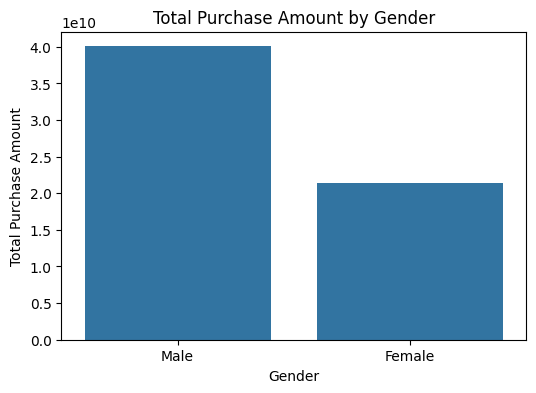

In [182]:
# 성별에 따른 총 구매 금액 시각화
gender_purchase = data.groupby('sex')['sale_amt'].sum().reset_index()
gender_purchase['sex'] = gender_purchase['sex'].map({1: 'Male', 2: 'Female'})

plt.figure(figsize=(6, 4))
sns.barplot(x='sex', y='sale_amt', data=gender_purchase)
plt.title('Total Purchase Amount by Gender')
plt.xlabel('Gender')
plt.ylabel('Total Purchase Amount')
plt.show()

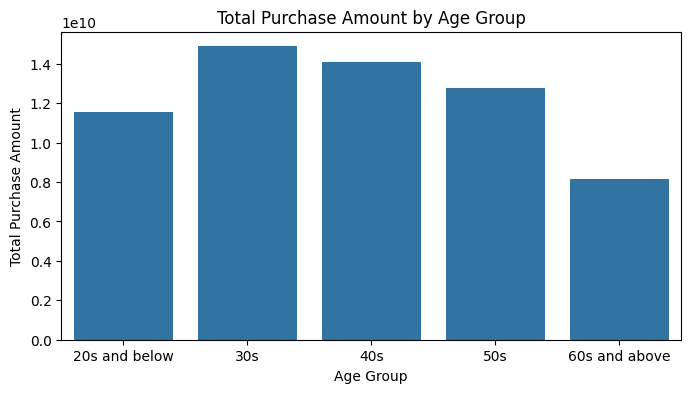

In [183]:
# 연령대별 총 구매 금액 시각화
age_purchase = data.groupby('age')['sale_amt'].sum().reset_index()
age_purchase['age_group'] = age_purchase['age'].map({
    1: '20s and below', 2: '30s', 3: '40s', 4: '50s', 5: '60s and above'
})

plt.figure(figsize=(8, 4))
sns.barplot(x='age_group', y='sale_amt', data=age_purchase, order=[
    '20s and below', '30s', '40s', '50s', '60s and above'
])
plt.title('Total Purchase Amount by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Purchase Amount')
plt.show()


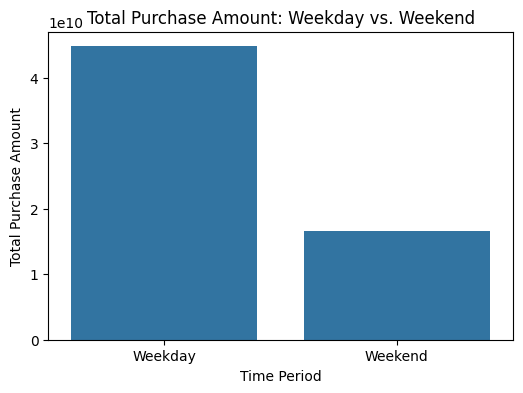

In [184]:
# 주말과 주중에 따른 총 구매 금액 시각화
weekend_purchase = data.groupby('weekend')['sale_amt'].sum().reset_index()
weekend_purchase['weekend'] = weekend_purchase['weekend'].map({0: 'Weekday', 1: 'Weekend'})

plt.figure(figsize=(6, 4))
sns.barplot(x='weekend', y='sale_amt', data=weekend_purchase)
plt.title('Total Purchase Amount: Weekday vs. Weekend')
plt.xlabel('Time Period')
plt.ylabel('Total Purchase Amount')
plt.show()


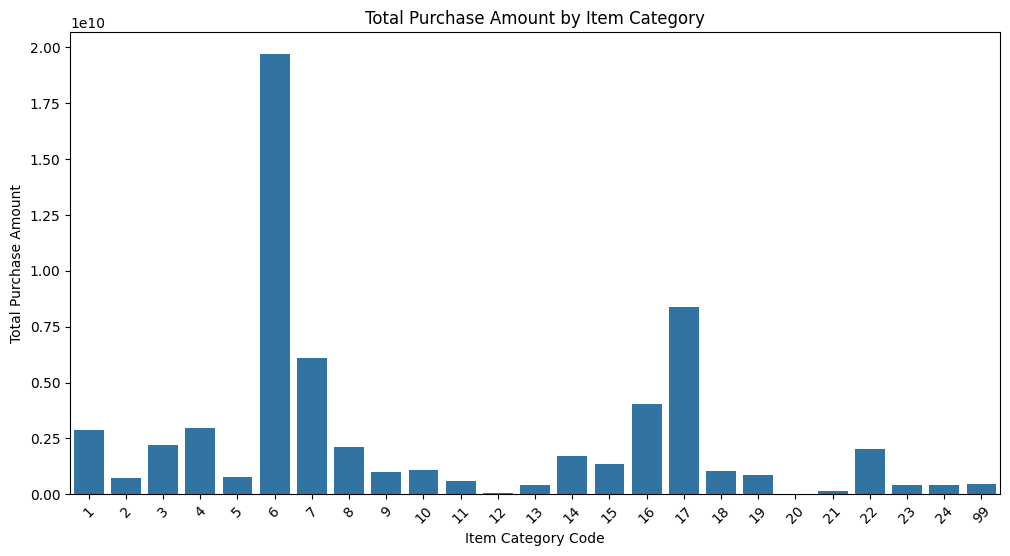

In [185]:
# 품목별 총 구매 금액 시각화
item_purchase = data.groupby('lclss')['sale_amt'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='lclss', y='sale_amt', data=item_purchase)
plt.title('Total Purchase Amount by Item Category')
plt.xlabel('Item Category Code')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.show()


<ipython-input-186-723616ca3a56>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = data['yyyymm'].astype(str).str[:4] + '-' + data['yyyymm'].astype(str).str[4:6]


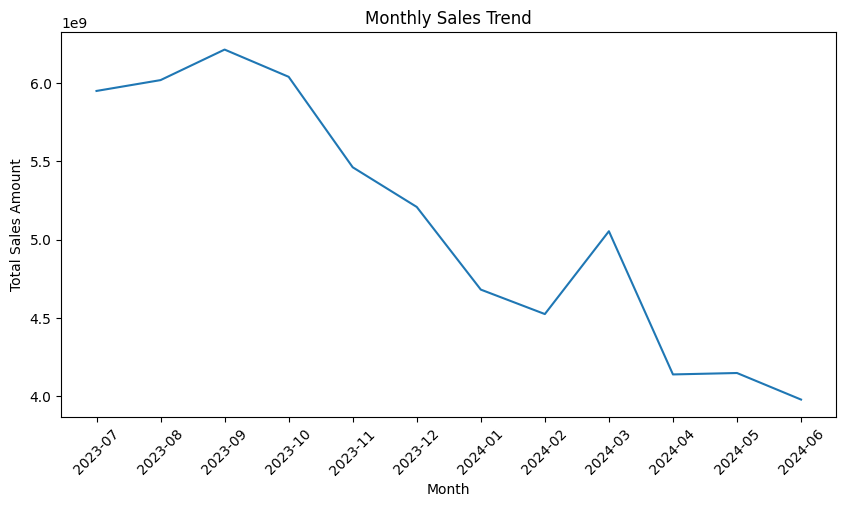

In [186]:
# 월별 매출 데이터 집계
data['month'] = data['yyyymm'].astype(str).str[:4] + '-' + data['yyyymm'].astype(str).str[4:6]
monthly_sales = data.groupby('month')['sale_amt'].sum().reset_index()

# 시각화
plt.figure(figsize=(10, 5))
sns.lineplot(x='month', y='sale_amt', data=monthly_sales)
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.show()


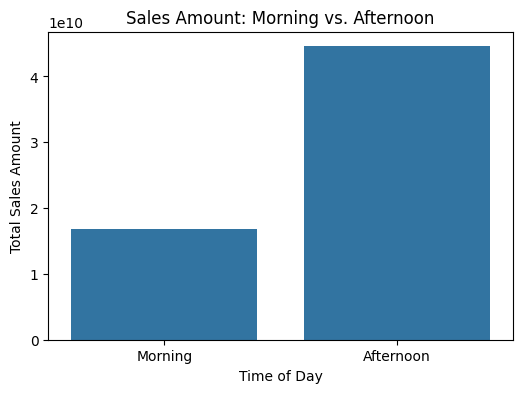

In [187]:
# 오전과 오후의 매출 분석
time_of_day_sales = data.groupby('aftern')['sale_amt'].sum().reset_index()
time_of_day_sales['aftern'] = time_of_day_sales['aftern'].map({0: 'Morning', 1: 'Afternoon'})

plt.figure(figsize=(6, 4))
sns.barplot(x='aftern', y='sale_amt', data=time_of_day_sales)
plt.title('Sales Amount: Morning vs. Afternoon')
plt.xlabel('Time of Day')
plt.ylabel('Total Sales Amount')
plt.show()


In [188]:
# 구매 빈도가 높은 고객 분석
high_frequency_customers = data.groupby('user_id')['sale_cnt'].sum().reset_index().sort_values(by='sale_cnt', ascending=False)
print("Top 5 High-Frequency Shoppers:\n", high_frequency_customers.head(5))


Top 5 High-Frequency Shoppers:
     user_id  sale_cnt
1  11.0_1_2   2210039
2  11.0_1_3   1975007
3  11.0_1_4   1691347
0  11.0_1_1   1539396
5  11.0_2_1   1451986
